<h1 align="center"><b>Project Unit 02 - Customer Classification</b></h1>
<h3 align="center"><b style="color:gray">Using XGBoost Classifier instead of Random Forest or Extra Trees</b></h1>
<h3><b>Table of Contents</b></h3>
<ul style = "list-style-type: none; line-height: 0.5em;">
    <li><a href="#parameters"><h5>1. Project Parameters</h5></a></li>
    <li><a href="#data"><h5>2. Data Preprocessing</h5></a></li>
    <li><a href="#definition"><h5>3. Target and Features Definition</h5></a></li>
    <li><a href="#conclusion"><h5>4. Train and Test Split</h5></a></li>
    <li><a href="#references"><h5>5. Initial Model and Feature Importance</h5></a></li>
    <li><a href="#references"><h5>6. Final Model and Results</h5></a></li>
</ul>

<h2 id="parameters"><b>1. Project Parameters</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [1]:
DATA_PATH = "./../data/BBDD_V7_SINCO_SoftImputer.csv"
KPI = "BMA_corregido"
TEST_SIZE = 0.3
THRESHOLD = 0.0
TARGET = "true_class"
FEATURES_TO_SELECT = 0.05

<h2 id="data"><b>2. Data Preprocessing</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [2]:
import pandas as pd

data = pd.read_csv(DATA_PATH)
data = data.drop(columns = ["PrimaTotalPoliza", "ComisionTotalPoliza", "SiniestralidadTotalPoliza", "ExposicionTotalPoliza"])

print(f"Data from '{DATA_PATH}' loaded with {len(data):,} rows and {len(data.columns)} columns.")
data.head()

Data from './../data/BBDD_V7_SINCO_SoftImputer.csv' loaded with 116,934 rows and 196 columns.


,id17,id18,id21,id55,id58_1,id58_2,id58_3,id59,id60,id61,...,Subramo_TURISMO_NO_CUADRICICLOS,Subramo_VEHICULOS_AGRICOLAS,Subramo_VEHICULOS_INDUSTRIALES,TipoConsultaSINCO_Tomador,NotaLUA_B,NotaLUA_C,NotaLUA_D,NotaLUA_E,NotaLUA_F,NotaLUA_G
0,31.0,403.0,3710.0,-50.0,1.0,0.0,0.0,6072.07,913.94,3405.92,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,35.0,40.0,3440.0,-50.0,2.0,1.0,1.0,36842.45,4673.69,13172.78,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,180.0,56.0,41840.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,31.0,403.0,3710.0,-5.0,0.0,0.0,0.0,0.00,0.00,0.00,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,600.0,80.0,3001.0,-50.0,0.0,0.0,0.0,0.00,0.00,0.00,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
data = data[data["SINCO"] != 0]
print(f"Data after removing rows without SINCO data has {len(data):,} rows and {len(data.columns)} columns.")

missing_data = data.isna().sum()
print(f"There are {missing_data.sum()} cells with no data.")

Data after removing rows without SINCO data has 51,618 rows and 196 columns.
There are 0 cells with no data.


<h2 id="definition"><b>3. Target and Features Definition</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [4]:
print(f"Summary of statistics for KPI variable '{KPI}' in X.")
data[KPI].describe()

Summary of statistics for KPI variable 'BMA_corregido' in X.


count     51618.000000
mean         17.627195
std        2277.249644
min     -185990.403750
25%          72.806400
50%         177.665708
75%         262.404322
max       21746.517500
Name: BMA_corregido, dtype: float64

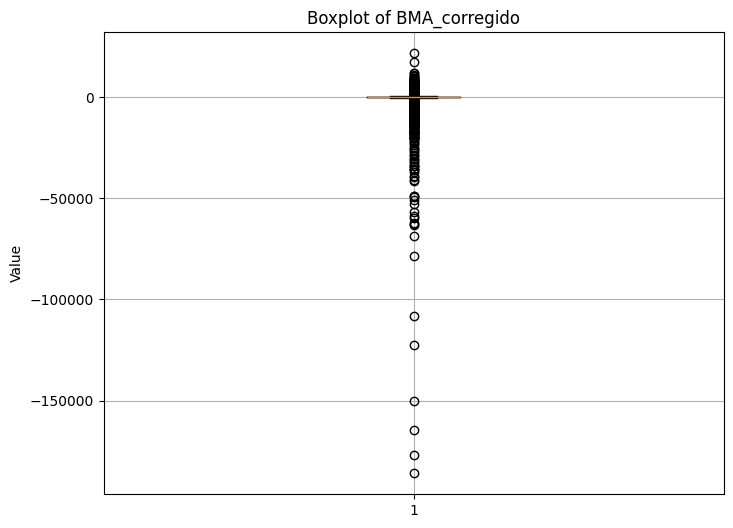

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 6))
plt.boxplot(data[KPI], vert = True)
plt.title(f"Boxplot of {KPI}")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [6]:
import numpy as np

print(f"True class of each customer: 0 (selected) if '{KPI}' > {THRESHOLD}, otherwise 1 (excluded)")
data[TARGET] = np.where(data[KPI] > THRESHOLD, 0, 1)

True class of each customer: 0 (selected) if 'BMA_corregido' > 0.0, otherwise 1 (excluded)


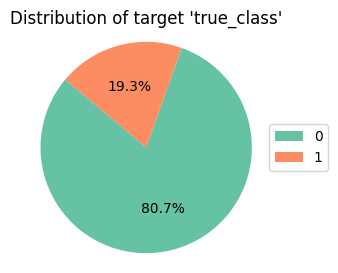

In [7]:
target_counts = data[TARGET].value_counts()
colors = ["#66c2a5", "#fc8d62"]
plt.figure(figsize=(3, 3))
plt.pie(target_counts, autopct = "%1.1f%%", startangle=140, colors=colors)
plt.axis("equal") # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels=target_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(f"Distribution of target '{TARGET}'")
plt.show()

In [8]:
print(f"Total customers in dataset: {len(data):,} customers in data")
max_benefit = data[data[KPI] > 0][KPI].sum()
real_benefit = data[KPI].sum()
p_r_benefit = int(round(100 * real_benefit / max_benefit, 0))
avg_r_benefit = data[KPI].mean()
print(f"Based on KPI, maximum possible benefit in X: {max_benefit:,.0f} euros")
print(f"Based on KPI, real benefit before applying any model: {real_benefit:,.0f} euros ({p_r_benefit}% of max)")
print(f"Based on KPI, avg. benefit before applying any model: {avg_r_benefit:,.2f} euros per customer in dataset")

Total customers in dataset: 51,618 customers in data
Based on KPI, maximum possible benefit in X: 12,238,483 euros
Based on KPI, real benefit before applying any model: 909,881 euros (7% of max)
Based on KPI, avg. benefit before applying any model: 17.63 euros per customer in dataset


In [9]:
numerical_columns = data.select_dtypes(include=["number"]).columns
y = data[TARGET]
X = data[numerical_columns].drop(columns = ["BMA_pol", TARGET])

print(f"X data has {len(X):,} rows and {len(X.columns)} columns")
print(f"y data has {len(y):,} rows")

X data has 51,618 rows and 195 columns
y data has 51,618 rows


<h2 id="definition"><b>4. Train and Test Split</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [10]:
from sklearn.model_selection import train_test_split

# Split data into train_val_KPI and test_KPI sets
X_train_val_KPI, X_test_KPI, y_train_val, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
print('Shape of X_test_KPI:', X_test_KPI.shape)
print('Shape of y_test:', y_test.shape)

# Split train_val_KPI data into train_KPI and val_KPI sets
X_train_KPI, X_val_KPI, y_train, y_val = train_test_split(X_train_val_KPI, y_train_val, test_size=0.1, random_state=42)
print('Shape of X_train_KPI:', X_train_KPI.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val_KPI:', X_val_KPI.shape)
print('Shape of y_val:', y_val.shape)

# Define X_train, X_val and X_test, which will not contain the KPI
X_train = X_train_KPI.drop(columns=[KPI])
X_val = X_val_KPI.drop(columns=[KPI])
X_test = X_test_KPI.drop(columns=[KPI])
print('Shape of X_train:', X_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_test_KPI: (15486, 195)
Shape of y_test: (15486,)
Shape of X_train_KPI: (32518, 195)
Shape of y_train: (32518,)
Shape of X_val_KPI: (3614, 195)
Shape of y_val: (3614,)
Shape of X_train: (32518, 194)
Shape of X_val: (3614, 194)
Shape of X_test: (15486, 194)


<h2 id="definition"><b>5. Initial Model and Feature Importance</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [11]:
import time
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(model):
    train_pred_proba = model.predict_proba(X_train)[:,1]
    train_score = roc_auc_score(y_train, train_pred_proba)
    print('roc_auc score for TRAIN set:', round(train_score, 3))
    val_pred_proba = model.predict_proba(X_val)[:,1]
    val_score = roc_auc_score(y_val, val_pred_proba)
    print('roc_auc score for VAL set:', round(val_score, 3))
    test_pred_proba = model.predict_proba(X_test)[:,1]
    test_score = roc_auc_score(y_test, test_pred_proba)
    print('roc_auc score for TEST set (God mode):', round(test_score, 3))
    return val_score

start_time = time.time()
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
print(f"Model trained in {time.time() - start_time:.2f} seconds")
val_score = evaluate_model(xgb_model)

Model trained in 2.09 seconds
roc_auc score for TRAIN set: 0.958
roc_auc score for VAL set: 0.715
roc_auc score for TEST set (God mode): 0.708


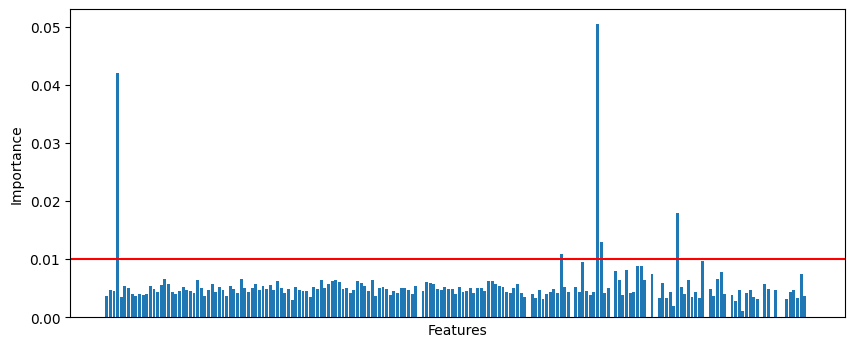

In [12]:
importances = xgb_model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(range(len(importances)), importances)
plt.axhline(y=0.01, color='red', linestyle='-')
plt.xticks([])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [13]:
feature_names = X_train.columns.values
num_features_to_select = int(FEATURES_TO_SELECT * len(importances))
sorted_features = np.argsort(importances)[::-1]
top_features = sorted_features[:num_features_to_select]
top_feature_names = feature_names[top_features]

print('The following (sorted) features are the most important ones:')
print(top_feature_names)

The following (sorted) features are the most important ones:
['Result_siniestros_SINCO' 'id55' 'Cliente_Diverso' 'AnyoPoliza'
 'PerteneceSINCO' 'id13_H' 'FrecuenciaSiniestroSINCO'
 'NumeroDanyosMaterialesSINCO' 'id72_2']


In [14]:
X_train = X_train[top_feature_names]  
X_val = X_val[top_feature_names]  
X_test = X_test[top_feature_names]  
print('Only important features are being considered...')  
print('Shape of X_train reduced:', X_train.shape)  
print('Shape of X_val reduced:', X_val.shape)  
print('Shape of X_test reduced:', X_test.shape)

Only important features are being considered...
Shape of X_train reduced: (32518, 9)
Shape of X_val reduced: (3614, 9)
Shape of X_test reduced: (15486, 9)


<h2 id="definition"><b>6. Final Model and Results</b></h2>
<div style="margin: 1em;">
    <p style="text-align: justify;">
    </p>
</div>

In [15]:
start_time = time.time()  
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train, y_train)  
print(f"Model trained, elapsed: {time.time() - start_time:.0f} seconds")
val_score = evaluate_model(xgb_model)  


Model trained, elapsed: 0 seconds
roc_auc score for TRAIN set: 0.796
roc_auc score for VAL set: 0.717
roc_auc score for TEST set (God mode): 0.709


In [16]:
print(f"Total customers in X_train_val: {X_train_val_KPI.shape[0]:.0f} customers")
max_benefit_train = X_train_val_KPI[X_train_val_KPI[KPI] > 0][KPI].sum()
real_benefit_train = X_train_val_KPI[KPI].sum()
p_real_benefit_train = int(round(100 * real_benefit_train / max_benefit_train, 0))
avg_real_benefit_train = X_train_val_KPI[KPI].mean()
print(f"Maximum possible benefit in X_train_val: {max_benefit_train:.0f} euros")
print(f"Train_val real benefit before models: {real_benefit_train:.0f} euros ({p_real_benefit_train}% of max)")
print(f"Train_val avg. benefit before models: {avg_real_benefit_train:.2f} euros per cust. in dataset")

Total customers in X_train_val: 36132 customers
Maximum possible benefit in X_train_val: 8563637 euros
Train_val real benefit before models: 503874 euros (6% of max)
Train_val avg. benefit before models: 13.95 euros per cust. in dataset


In [17]:
def calc_benefits(predictions, X):
    def print_descriptive_stats(stats):
        print(f"Count={stats['count']:.0f}; "
              f"Mean={stats['mean']:.0f}; "
              f"Std={stats['std']:.0f}; "
              f"Min={stats['min']:.0f}; "
              f"Q1={stats['25%']:.0f}; "
              f"Q2={stats['50%']:.0f}; "
              f"Q3={stats['75%']:.0f}; "
              f"Max={stats['max']:.0f}")
    X['class_predicted'] = predictions
    n_customers = len(predictions)
    
    # Filter dataset to select only selected customers (class 0)
    selected = X[X['class_predicted'] == 0]
    excluded = X[X['class_predicted'] == 1]
    others = X[~X.index.isin(selected.index) & ~X.index.isin(excluded.index)]
    n_selected = len(selected)
    n_excluded = len(excluded)
    n_others = len(others)
        
    max_benefit = X[X[KPI] > 0][KPI].sum()
    r_benefit = X[KPI].sum() # real (actual) benefit without applying models
    p_r_benefit = int(round(100 * r_benefit / max_benefit, 0)) # percentage real benefit
    avg_r_benefit = r_benefit/n_customers # average real benefit per customer in dataset
    m_benefit = selected[KPI].sum()
    p_m_benefit = int(round(100 * m_benefit / max_benefit, 0))
    avg_m_benefit = m_benefit/n_customers # average model benefit per customer in dataset

    # default:
    print(f"\nMaximum possible benefit in dataset: {max_benefit:,.0f} euros")
    print(f"Real benefit before model: {r_benefit:,.0f} euros ({p_r_benefit}% of max)")
    print(f"Avg. benefit before model: {avg_r_benefit:,.2f} euros per cust. in dataset")
    print(f"Est. benefit after model: {m_benefit:,.0f} euros ({p_m_benefit}% of max)")
    print(f"Avg. benefit after model: {avg_m_benefit:,.2f} euros per customer in dataset")

    print(f"\n\nDescriptive statistics for selected (accepted) customers:")
    stats_s = selected[KPI].describe()
    print_descriptive_stats(stats_s)
    stats_e = excluded[KPI].describe()
    print(f"\nDescriptive statistics for excluded customers:")
    print_descriptive_stats(stats_e)
    
    # Additional analysis
    selected_positive = selected[selected[KPI] > 0]
    selected_negative = selected[selected[KPI] <= 0]
    excluded_positive = excluded[excluded[KPI] > 0]
    excluded_negative = excluded[excluded[KPI] <= 0]
    
    print(f"\nSelected customers with positive KPI: {len(selected_positive):,}")
    print(f"Selected customers with negative (or zero) KPI: {len(selected_negative):,}")
    print(f"Excluded customers with positive KPI: {len(excluded_positive):,}")
    print(f"Excluded customers with negative (or zero) KPI: {len(excluded_negative):,}")
    
    return m_benefit, avg_m_benefit

pred_test = xgb_model.predict(X_test)
pred_test_proba = xgb_model.predict_proba(X_test)[:, 1]
X_test_KPI = pd.DataFrame(X_test_KPI)
benefits = calc_benefits(pred_test, X_test_KPI)


Maximum possible benefit in dataset: 3,674,846 euros
Real benefit before model: 406,006 euros (11% of max)
Avg. benefit before model: 26.22 euros per cust. in dataset
Est. benefit after model: 1,227,273 euros (33% of max)
Avg. benefit after model: 79.25 euros per customer in dataset


Descriptive statistics for selected (accepted) customers:
Count=14356; Mean=85; Std=1990; Min=-176973; Q1=93; Q2=183; Q3=267; Max=11774

Descriptive statistics for excluded customers:
Count=1130; Mean=-727; Std=4379; Min=-122770; Q1=-664; Q2=-184; Q3=129; Max=2947

Selected customers with positive KPI: 12,130
Selected customers with negative (or zero) KPI: 2,226
Excluded customers with positive KPI: 383
Excluded customers with negative (or zero) KPI: 747


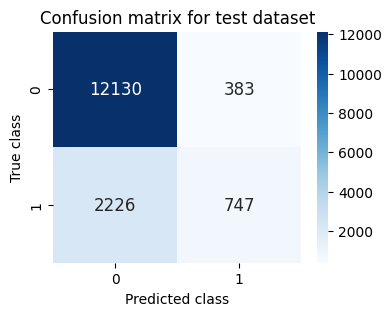

In [18]:
import seaborn as sns

def plot_cf(cf, color):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cf, annot=True, fmt='d', cmap=color, annot_kws={"fontsize": 12})
    plt.title('Confusion matrix for test dataset')
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    plt.show()

plot_cf(confusion_matrix(y_test, pred_test), 'Blues')

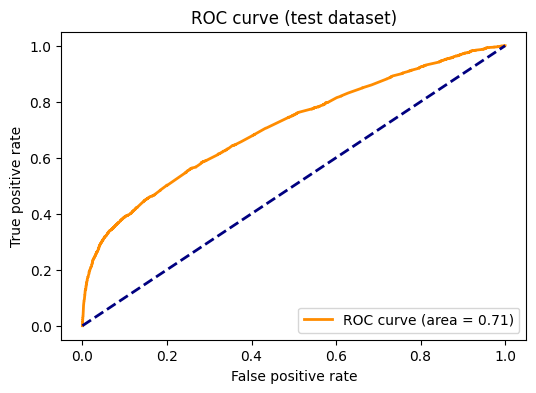

In [19]:
def plot_roc(fpr, tpr, roc_auc):
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (test dataset)')
    plt.legend(loc='lower right')
    plt.show()

fpr, tpr, thresholds = roc_curve(y_test, pred_test_proba)
roc_auc = roc_auc_score(y_test, pred_test_proba)
plot_roc(fpr, tpr, roc_auc)